# Testing of Data Augmentation using Wigner rotations!

In [1]:
import numpy as np
import quaternion
import spherical_functions as sf
from scf_guess_tools import Backend, load, calculate
import matplotlib.pyplot as plt

We will test on water!

In [2]:
# no rotation: 
mol_no_rot = load('data/h2o_1.xyz', Backend.PY, basis='sto-3g')
points = []
with open('data/h2o_1.xyz', 'r') as f:
    for line in f:
        if line.startswith('H') or line.startswith('O'):
            points.append([float(x) for x in line.split()[1:4]])
wf_no_rot = calculate(mol_no_rot, 'sto-3g', None, "dft", "b3lypg")
overlap_no_rot = wf_no_rot.overlap()
fock_no_rot = wf_no_rot.fock()
density_no_rot = wf_no_rot.density()

converged SCF energy = -75.3127008658446


In [3]:
def quick_imshow(matrix, title=None, vmax=1, threshold=1e-10):
    matrix = matrix.numpy if hasattr(matrix, 'numpy') else matrix
    matrix = matrix.copy()
    for (i, row) in enumerate(matrix):
        for (j, val) in enumerate(row):
            plt.text(j, i, f"{val:.2f}", ha="center", va="center", color="black", fontsize=8)
    matrix[np.abs(matrix) < threshold] = 0
    plt.imshow(matrix, cmap='RdBu', vmin=-vmax, vmax=vmax)
    plt.colorbar()
    if title:
        plt.title(title)
    plt.show()

In [4]:
from mpl_toolkits.mplot3d import Axes3D

def plot_xyz_points(points, labels=None, title="3D XYZ Points", lims=None):
    """
    Plots 3D xyz points.

    Args:
        points (np.ndarray): shape (N, 3)
        labels (list, optional): list of N labels for each point
        title (str): plot title
    """

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    xs, ys, zs = points[:,0], points[:,1], points[:,2]
    ax.scatter(xs, ys, zs, s=60)
    if labels is not None:
        for i, label in enumerate(labels):
            ax.text(xs[i], ys[i], zs[i], str(label))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    if lims: 
        ax.set_xlim(lims[0])
        ax.set_ylim(lims[1])
        ax.set_zlim(lims[2])
    ax.set_title(title)
    plt.show()

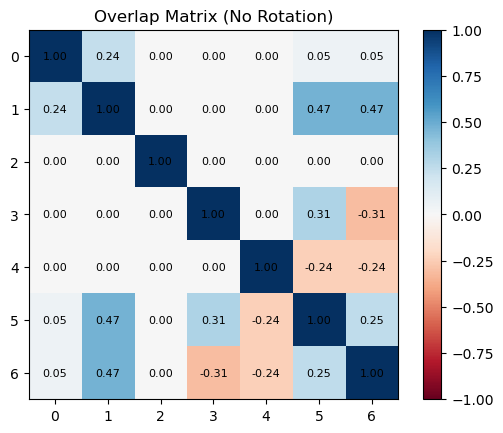

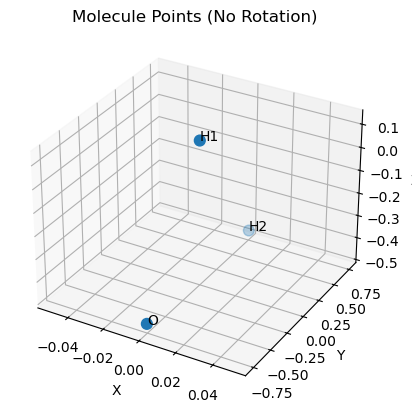

In [5]:
quick_imshow(overlap_no_rot, "Overlap Matrix (No Rotation)")
plot_xyz_points(np.array(points), labels=['H1', 'H2', 'O'], title="Molecule Points (No Rotation)")



In [6]:
def quaternion_from_axis_angle(axis, angle):
    half_angle = angle / 2
    s = np.sin(half_angle)
    c = np.cos(half_angle)
    return np.quaternion(c, *(axis * s))

def rotate_points(points, axis, angle):
    """
    Rotates points around a given axis by a specified angle.

    Args:
        points (np.ndarray): shape (N, 3)
        axis (np.ndarray): rotation axis
        angle (float): rotation angle in radians

    Returns:
        np.ndarray: rotated points
    """
    q = np.quaternion(np.cos(angle / 2), *(axis * np.sin(angle / 2)))
    q_conjugate = q.conjugate()
    rotated_points = []
    for point in points:
        p = np.quaternion(0, *point)
        rotated_point = q * p * q_conjugate
        rotated_points.append(rotated_point.imag)
    return np.array(rotated_points)


In [7]:
# rotation around z-axis by 45 degrees
rot_axis = np.array([0, 0, 1])
rot_axis = rot_axis / np.linalg.norm(rot_axis)  # Normalize the rotation axis
rot_angle = np.pi / 4  # 45 degrees in radians
rotated_points = rotate_points(np.array(points), rot_axis, rot_angle)
with open("data/h2o_1_rotated.xyz", 'w') as f:
    f.write(f"{len(rotated_points)}\n")
    f.write('Rotated molecule "h2o" dataset "non-multireference W4-17" charge 0 multiplicity 1\n')
    for i, point in enumerate(rotated_points):
        if i == 0:
            f.write(f"O {point[0]} {point[1]} {point[2]}\n")
        else:
            f.write(f"H {point[0]} {point[1]} {point[2]}\n")

In [8]:
# no rotation: 
mol_rot = load('data/h2o_1_rotated.xyz', Backend.PY, basis='sto-3g')
wf_rot = calculate(mol_rot, 'sto-3g', None, "dft", "b3lypg")
overlap_rot = wf_rot.overlap()
fock_rot = wf_rot.fock()
density_rot = wf_rot.density()

converged SCF energy = -75.3127002824111


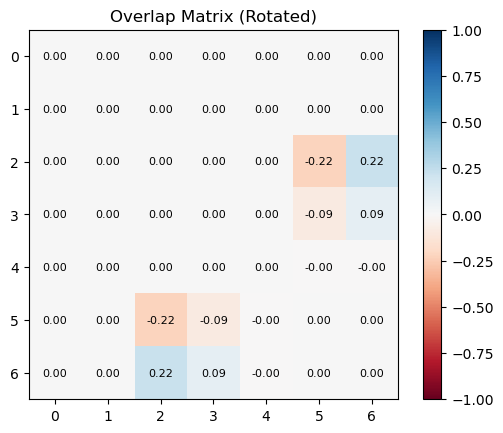

In [9]:
diff = overlap_rot - overlap_no_rot
quick_imshow(diff, "Overlap Matrix (Rotated)")

Difference in p-orbitals to be expected! Now transform with Wigner D matrices!

In [10]:
from collections import defaultdict
def wigner_D_matrix(l, R):
    """
    Build the full (2l+1)x(2l+1) Wigner-D^(l) matrix for
    the unit-quaternion rotation R.
    """
    ms      = np.arange(-l, l+1)
    # one row per (m',m)
    indices = np.array([[l, mp, m] for mp in ms for m in ms], dtype=int)
    elems   = sf.Wigner_D_element(R, indices)   # returns flat length (2l+1)^2
    return elems.reshape((2*l+1, 2*l+1))


def build_wigner_U(mol, axis, angle):
    """
    Build the AO‐basis rotation U (block‐diagonal in l=0,1,2,…) for a rotation
    of `angle` (rad) about the unit vector `axis`.  Uses mol.ao_labels(fmt=False).
    """
    l_map = {'s': 0, 'p': 1, 'd': 2, 'f': 3, 'g': 4}
    # 1) get raw AO labels: [(atom_idx, sym, L, ao_in_shell), …]
    ao_lbls = mol.ao_labels(fmt=False, base=0)
    nAO     = len(ao_lbls)

    # 2) group AO indices by (atom_idx, shell_name)
    shells = defaultdict(list)
    for mu, (iatom, _, shell_name, _) in enumerate(ao_lbls):
        shells[(iatom, shell_name)].append(mu)

    # 3) make the unit‐quaternion for the axis‐angle rotation
    axis = np.asarray(axis, float)
    axis = axis / np.linalg.norm(axis)
    # use numpy-quaternion’s from_rotation_vector (rotvec = axis*angle) :contentReference[oaicite:0]{index=0}
    q = quaternion.from_rotation_vector(axis * angle)

    # 4) build U
    U = np.eye(nAO, dtype=complex)
    for (iatom, shell_name), idxs in shells.items():
        l = l_map[shell_name[-1]]   # '2p'[-1] → 'p' → 1
        if l == 0:
            # s-shell: 1×1 identity, nothing to do
            continue

        # get the (2l+1)×(2l+1) Wigner-D block
        Dl = wigner_D_matrix(l, q)

        # sanity check: len(idxs) should == 2l+1
        if len(idxs) != 2*l+1:
            raise ValueError(f"Expected {2*l+1} AOs for shell {shell_name}, got {len(idxs)}")

        # insert into the big U
        U[np.ix_(idxs, idxs)] = Dl

    return U


def rotate_M(mol, axis, angle, M):
    """
    Rotate AO overlap S and Fock F by the Wigner‐D block-diag U inferred
    from the PySCF Mole object and return (S_rot, F_rot).
    """
    U = build_wigner_U(mol, axis, angle)
    M_rot = np.real_if_close(U @ M @ U.conjugate().T, tol=1e-8)
    
    return M_rot


Another try with pyscf Dmatrix

In [11]:
from pyscf.symm.Dmatrix import Dmatrix
from BlockMatrix import BlockMatrix, Block

In [12]:

def quaternion_to_euler_zyz(q): 
    """
    Convert a quaternion to Euler angles (Z-Y-Z convention).
    """

    # Extract the components of the quaternion
    w, x, y, z = q.w, q.x, q.y, q.z
    
    # Calculate the Euler angles
    phi = np.arctan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
    theta = np.arcsin(2 * (w * y - z * x))
    psi = np.arctan2(2 * (w * x + y * z), 1 - 2 * (x**2 + y**2))
    
    return phi, theta, psi

In [13]:
def rotate_M(mol, axis, angle, M):
    """
    Build the AO‐basis rotation U (block‐diagonal in l=0,1,2,…) for a rotation
    of `angle` (rad) about the unit vector `axis`.  Uses mol.ao_labels(fmt=False).
    """
    l_map = {'s': 0, 'p': 1, 'd': 2, 'f': 3, 'g': 4}
    # 1) get raw AO labels: [(atom_idx, sym, L, ao_in_shell), …]
    ao_lbls = mol.ao_labels(fmt=False, base=0)

    # 2) group AO indices by (atom_idx, shell_name)
    shells = defaultdict(list)
    for mu, (iatom, _, shell_name, _) in enumerate(ao_lbls):
        shells[(iatom, shell_name)].append(mu)

    # 3) make the unit‐quaternion for the axis‐angle rotation - try out euler to use pyscf's methods
    alpha, beta, gamma = quaternion_to_euler_zyz(quaternion_from_axis_angle(axis, angle))
    Dls = {l: Dmatrix(l, alpha, beta, gamma, reorder_p=True) for l in range(3)}  # we will surely not need more

    blocks_orig = M.blocks
    outM = M.copy()
    blocks_out = outM.blocks
    for key, block in blocks_orig.items(): # perform transformations block by block in sub-blocks (according to l)
        rows, cols = np.array(block.ls[0]), np.array(block.ls[1]) # l's of the rows and columns
        A = np.array(block.numpy, dtype=float)

        subblocks = {}
        for li in np.unique(rows):        # e.g. 0 then 1
            row_idx = np.where(rows == li)[0]
            for lj in np.unique(cols):    # e.g. 0 then 1
                if lj[-1] == 's' and li[-1] == 's': # skip s overlaps - no transformation
                    continue
                col_idx = np.where(cols == lj)[0]
                # this picks out the (li,lj) sub‐block
                sub = A[np.ix_(row_idx, col_idx)]
                subblocks[(li, lj)] = (row_idx, col_idx, sub)
        # transform and write back
        for (li,lj), (row_idx, col_idx, sub) in subblocks.items():
            # sanity check: len(idxs) should == 2l+1
            li, lj = l_map[li[-1]], l_map[lj[-1]]   # '2p'[-1] → 'p' → 1
            if len(row_idx) != 2*li+1 or len(col_idx) != 2*lj+1:
                raise ValueError(f"Expected {2*li+1} AOs for shell {shell_name}, got {len(row_idx)}")
            # insert back into block
            A[np.ix_(row_idx, col_idx)] = Dls[li] @ sub @ Dls[lj].T
        # overwrite the block with the transformed one
        blocks_out[key]._replace(A)
    return outM


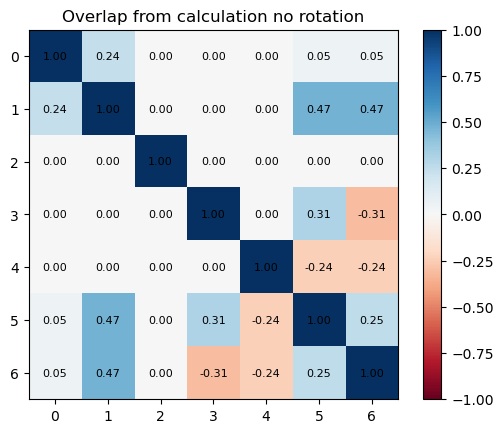

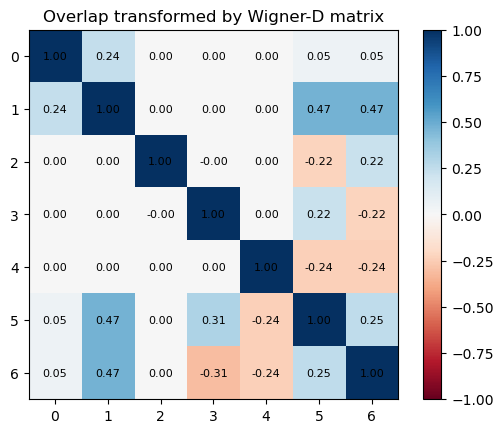

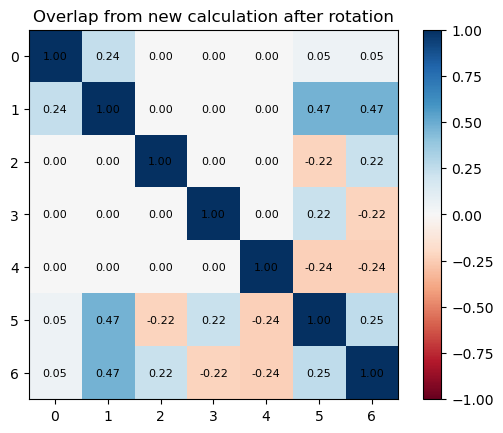

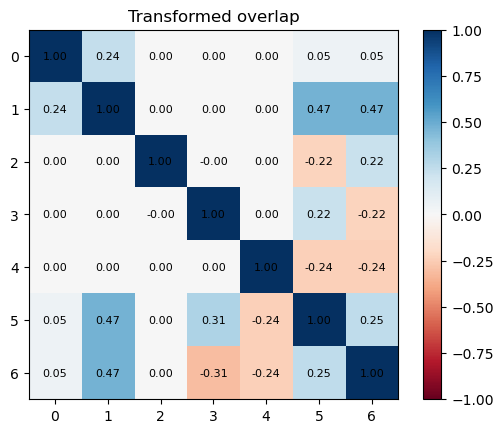

In [14]:

overlap_no_rot_block = BlockMatrix(mol_no_rot.native, overlap_no_rot.numpy)
overlap_trans = rotate_M(mol_no_rot.native, rot_axis, rot_angle, overlap_no_rot_block)


quick_imshow(overlap_no_rot.numpy, "Overlap from calculation no rotation", threshold=1e-16)
quick_imshow(overlap_trans.Matrix, "Overlap transformed by Wigner-D matrix")
quick_imshow(overlap_rot.numpy, "Overlap from new calculation after rotation")
quick_imshow(overlap_trans.Matrix, "Transformed overlap")
# quick_imshow(overlap_no_rot.numpy - overlap_rot.numpy, "Difference between no rotation and new calculation overlap", vmax=1e-4)


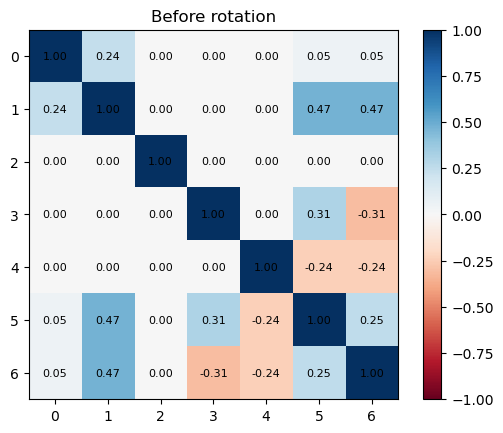

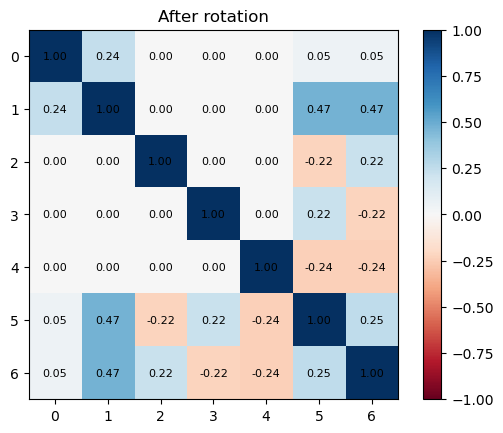

In [15]:
quick_imshow(overlap_no_rot.numpy, "Before rotation")
quick_imshow(overlap_rot.numpy, "After rotation")